# Inteligencia Artificial<a class="tocSkip">
## Machine Learning <a class="tocSkip">
### Ingenieria Electrónica <a class="tocSkip">
### Universidad Popular del Cesar <a class="tocSkip">
### Prof.: Jose Ramón Iglesias Gamarra - [https://github.com/joseramoniglesias/](https://github.com/joseramoniglesias/) <a class="tocSkip">
  **joseiglesias@unicesar.edu.co**

# Ejemplo de uso de Embeddings

La intención de este notebook es realizar un ejemplo que no sea NLP utilizando Embeddings con Keras

## Importamos librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam

## Creamos una serie temporal Fake

La idea del ejercicio será comparar el uso de valores categóricos "simples" <br>y ver cuánto mejoran con embeddings (o no)

In [2]:
ventas_falsas=pd.DataFrame()

anio=[]
mes=[]
dias=[]
vtas=[]
clientes=[]
cliente=1000
for a in range(1,5):
    for m in range(1,13):
        for i in range(0,30):
            anio.append(a)
            mes.append(m)
            dias.append(i%7)
            cliente = (cliente/3) + (i+1+(m*2)+(a*2))
            clientes.append(cliente)
            if i==0:
                vtas.append(0.0) # los domingos esta cerrado
            else:
                if m<4:
                    dinero = ((i%7) * cliente * 5)
                if m<8:
                    dinero = ((i%7) * cliente * 15)
                else:
                    dinero = ((i%7) * cliente * 25)
                if(i==5):
                    dinero = dinero*1.25 #los viernes vende mas
                if(i==3):
                    dinero = dinero*0.75 #los miercoles vende menos
                vtas.append(dinero)

ventas_falsas['anio']=anio
ventas_falsas['mes']=mes
ventas_falsas['dia']=dias
ventas_falsas['clientes']=clientes
ventas_falsas['ventas']=vtas

ventas_falsas.head()

,anio,mes,dia,clientes,ventas
0,1,1,0,338.333333,0.000000
1,1,1,1,118.777778,1781.666667
2,1,1,2,46.592593,1397.777778
3,1,1,3,23.530864,794.166667
4,1,1,4,16.843621,1010.617284


In [3]:
# Normalize time series data
# prepare data for normalization
values = ventas_falsas['ventas'].values
values = values.reshape((len(values), 1))
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print the first 5 rows
normalized = scaler.transform(values)
for i in range(5):
    print(normalized[i])
# inverse transform and print the first 5 rows
inversed = scaler.inverse_transform(normalized)
for i in range(5):
    print(inversed[i])


Min: 0.000000, Max: 13387.500000
[0.]
[0.13308434]
[0.10440917]
[0.05932151]
[0.07548962]
[0.]
[1781.66666667]
[1397.77777778]
[794.16666667]
[1010.61728395]


In [4]:
values2 = ventas_falsas['clientes'].values
values2 = values2.reshape((len(values), 1))
# train the normalization
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler2 = scaler2.fit(values2)
print('Min: %f, Max: %f' % (scaler2.data_min_, scaler2.data_max_))
# normalize the dataset and print the first 5 rows
normalized2 = scaler2.transform(values2)

ventas_falsas['clientes']=normalized2
ventas_falsas['ventas']=normalized

training_data=ventas_falsas.drop(['ventas'],1)
target_data=ventas_falsas['ventas']

ventas_falsas.head()

Min: 14.305556, Max: 338.333333


C:\Users\joser\AppData\Local\Temp\ipykernel_582660\4252456264.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  training_data=ventas_falsas.drop(['ventas'],1)


,anio,mes,dia,clientes,ventas
0,1,1,0,1.000000,0.000000
1,1,1,1,0.322417,0.133084
2,1,1,2,0.099643,0.104409
3,1,1,3,0.028471,0.059322
4,1,1,4,0.007833,0.075490


<Axes: >

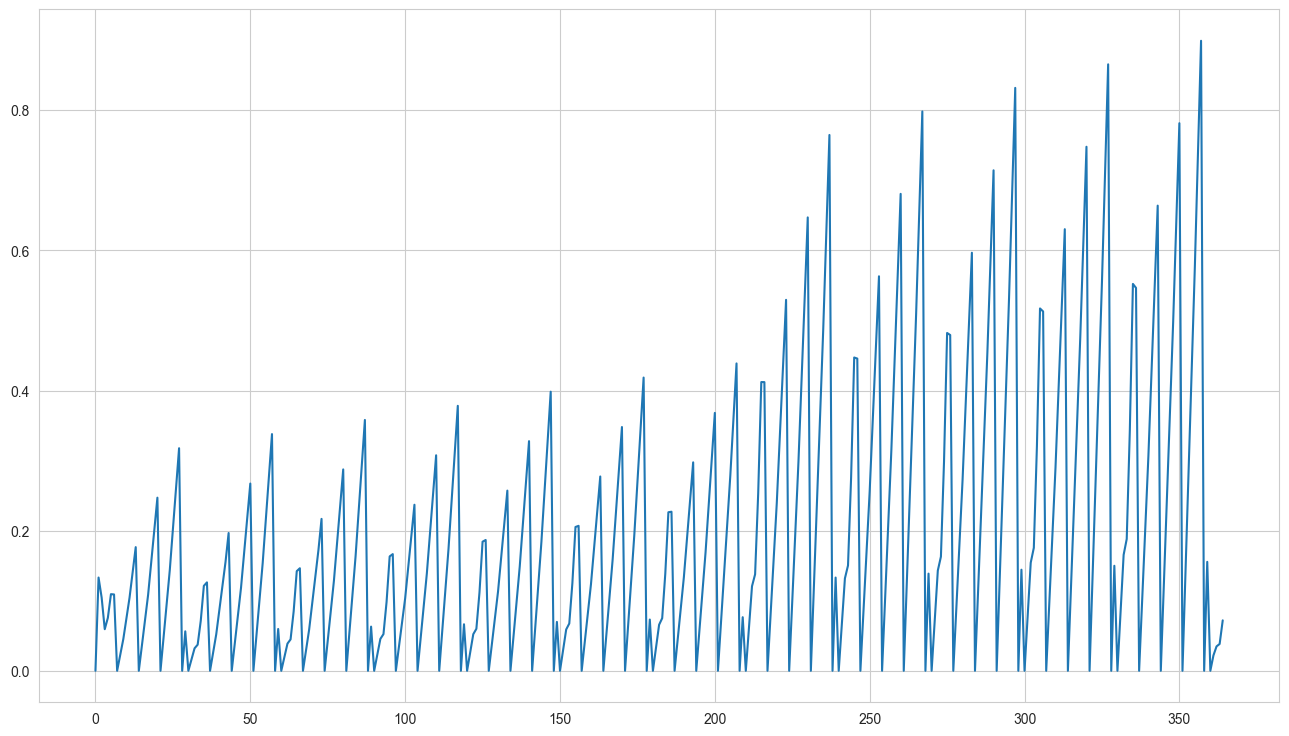

In [5]:
ventas_falsas['ventas'][0:365].plot() # Visualizamos el 1er anio
#ventas_falsas['ventas'][366:365*2].plot()
#ventas_falsas['ventas'][366+366:365*3].plot()

Lo que queremos ver, es la predicción con una red neuronal normal usando semana como categ.<br>
y ver con otra red pero con Embeddings, si mejora.

## Parametros

In [6]:
#Configuraciones generales
EPOCHS=50
dense_n = 20
cuantos=250 #para graficar
fun_act='sigmoid' #Probado también con tanh relu

## Subdividimos el Set en entrenamiento y Validación

In [7]:
training_data.shape

(1440, 4)

In [8]:
valid_data = training_data[1000:1440]
valid_target=target_data[1000:1440]
valid_target.shape

(440,)

In [9]:
training_data = training_data[0:1000]
target_data=target_data[0:1000]
target_data.shape

(1000,)

# 1 -Red Neuronal - Sin Embeddings

Creamos una red neuronal de una capa para predecir precios

In [10]:
model0 = Sequential()
model0.add(Dense(dense_n, input_dim=4, activation=fun_act))
model0.add(Dense(1, activation=fun_act))

model0.compile(loss='mean_squared_error', 
              optimizer='adam',
              metrics=['MSE'])

model0.summary()

history=model0.fit(training_data, target_data, epochs=EPOCHS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                100       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
32/32 [==============================] - 1s 2ms/step - loss: 0.0402 - MSE: 0.0402
Epoch 2/50
32/32 [==============================] - 0s 1ms/step - loss: 0.0340 - MSE: 0.0340
Epoch 3/50
32/32 [==============================] - 0s 1ms/step - loss: 0.0311 - MSE: 0.0311
Epoch 4/50
32/32 [==============================] - 0s 1ms/step - loss: 0.0283 - MSE: 0.0283
Epoch 5/50
32/32 [==============================] - 0s 1ms/step - loss: 0.0255 - M

In [11]:
# evaluamos el modelo
scores = model0.evaluate(training_data, target_data)
print("\n%s: %.4f" % (model0.metrics_names[1], scores[1]))

scores = model0.evaluate(valid_data, valid_target)
print("\n%s: %.4f" % (model0.metrics_names[1], scores[1]))

32/32 [==============================] - 0s 1ms/step - loss: 0.0053 - MSE: 0.0053

MSE: 0.0053
14/14 [==============================] - 0s 1ms/step - loss: 0.0113 - MSE: 0.0113

MSE: 0.0113


14/14 [==============================] - 0s 1ms/step
440


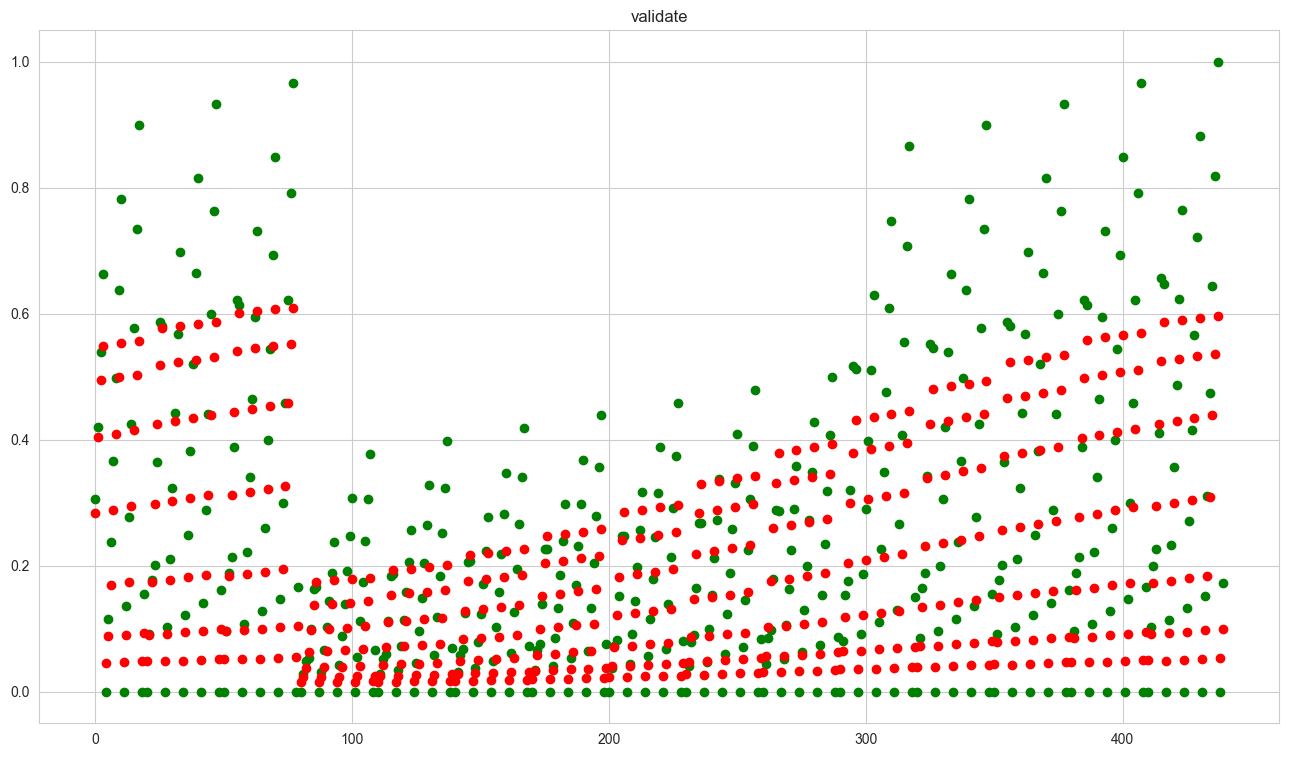

In [12]:
results=model0.predict(valid_data)
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

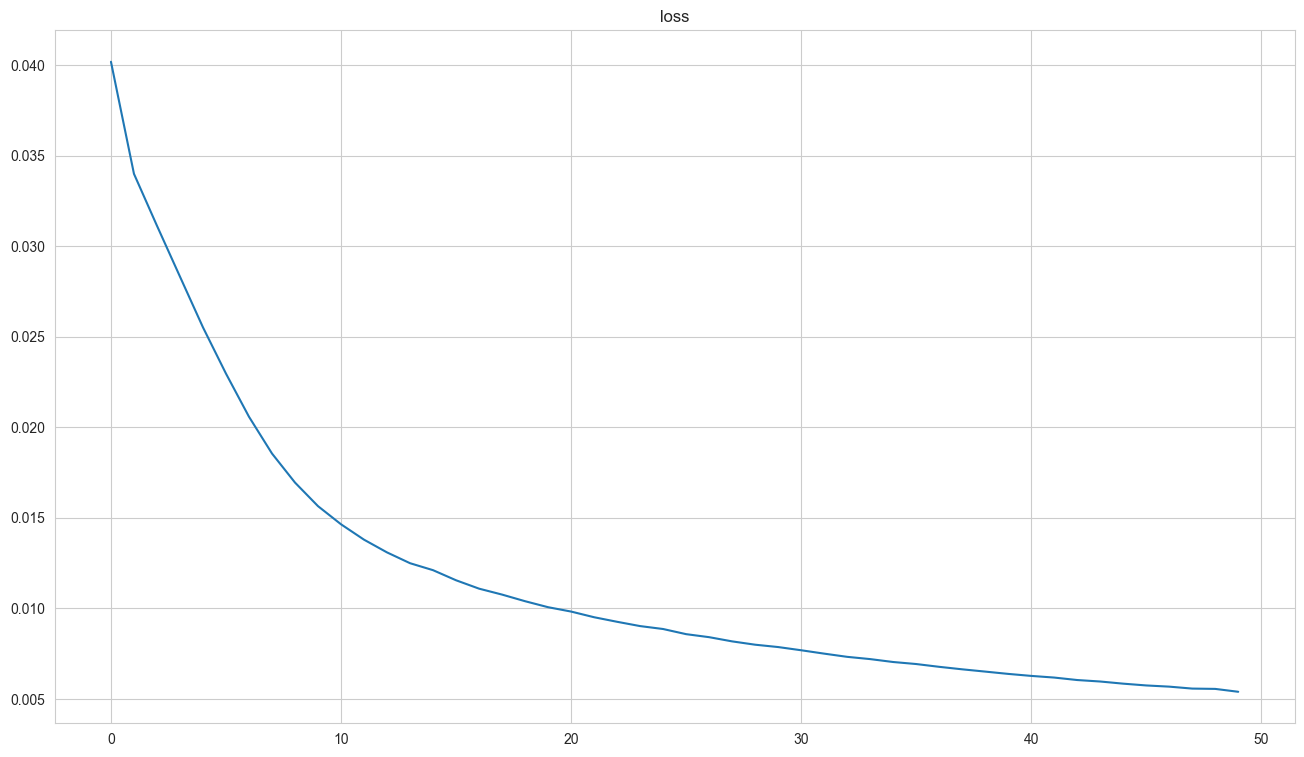

In [13]:
plt.plot(history.history['loss'])
plt.title('loss')
#plt.plot(history.history['mean_squared_error'])
#plt.title('validate loss')
plt.show()

# 2 - Red Neuronal - con Embeddings

In [14]:
emb_n = 30#tamanio profundidad de embeddings

in_dias = Input(shape=[1], name = 'dias')
emb_dias = Embedding(7, emb_n)(in_dias)
in_meses = Input(shape=[1], name = 'meses')
emb_meses = Embedding(13, emb_n)(in_meses)
in_anios = Input(shape=[1], name = 'anios')
emb_anios = Embedding(6, emb_n)(in_anios)

in_cli = Input(shape=[1], name = 'cli')

fe = concatenate([(emb_dias), (emb_meses),(emb_anios)])

x = Flatten()(fe)
x = Dense(dense_n,activation=fun_act)(x)
outp = Dense(1,activation=fun_act)(x)
model = Model(inputs=[in_dias,in_meses,in_anios,in_cli], outputs=outp)

model.compile(loss='mean_squared_error', 
              optimizer='adam',
              metrics=['MSE'])

model.summary()

history=model.fit([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']], target_data, epochs=EPOCHS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dias (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 meses (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 anios (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 30)        210         ['dias[0][0]']                   
                                                                                              

In [15]:
# evaluamos el modelo
scores = model.evaluate([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']], target_data)
print("\n%s: %.4f" % (model.metrics_names[1], scores[1]))

scores = model.evaluate([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']], valid_target)
print("\n%s: %.4f" % (model.metrics_names[1], scores[1]))


32/32 [==============================] - 0s 1ms/step - loss: 0.0037 - MSE: 0.0037

MSE: 0.0037
14/14 [==============================] - 0s 2ms/step - loss: 0.0049 - MSE: 0.0049

MSE: 0.0049


14/14 [==============================] - 0s 1ms/step
440


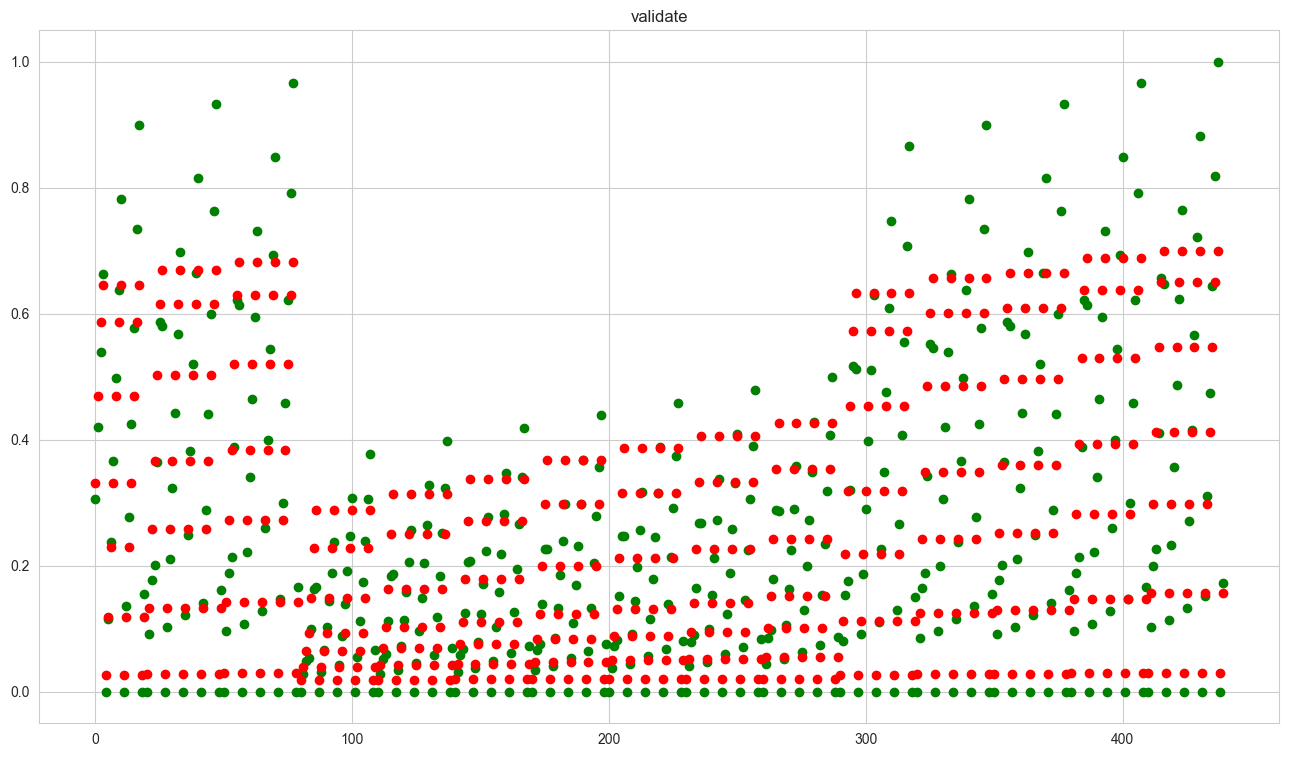

In [16]:
results=model.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

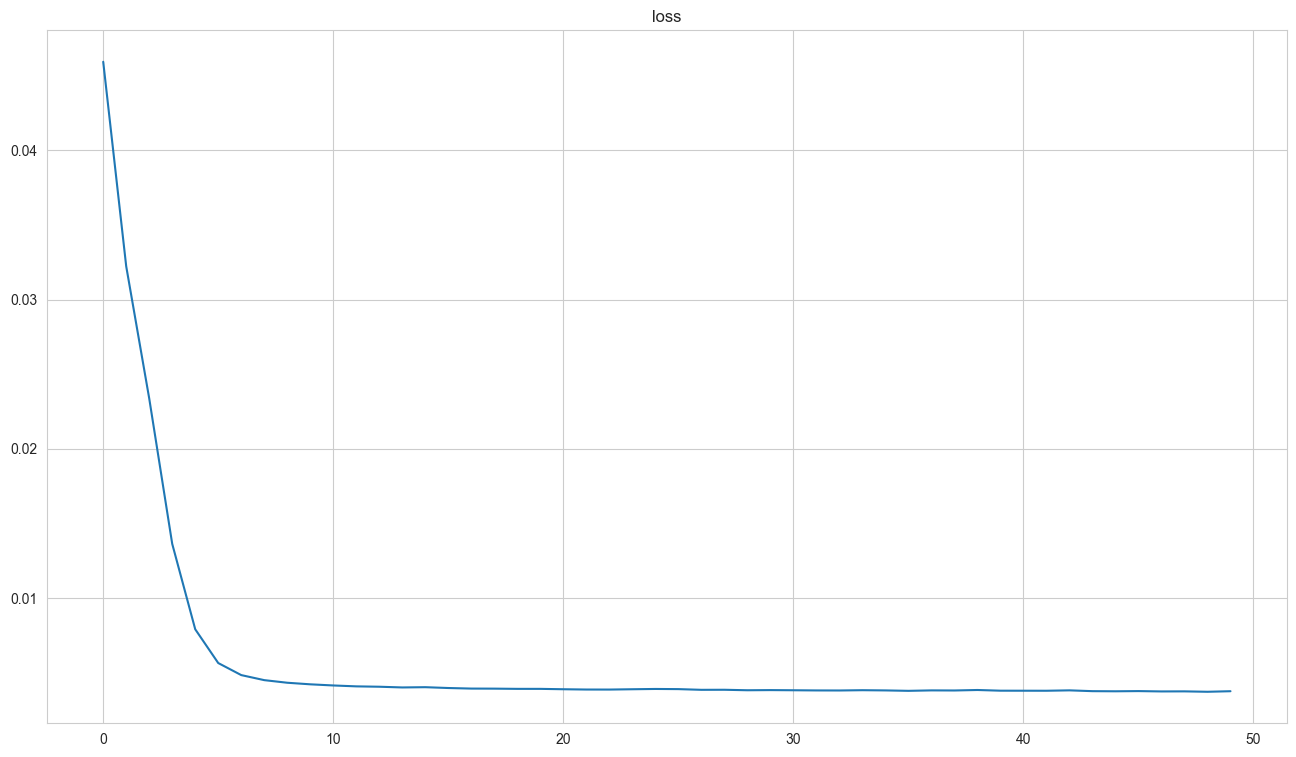

In [17]:
plt.plot(history.history['loss'])
plt.title('loss')
#plt.plot(history.history['mean_squared_error'])
#plt.title('validate loss')
plt.show()

# Comparamos Visualmente

32/32 [==============================] - 0s 1ms/step


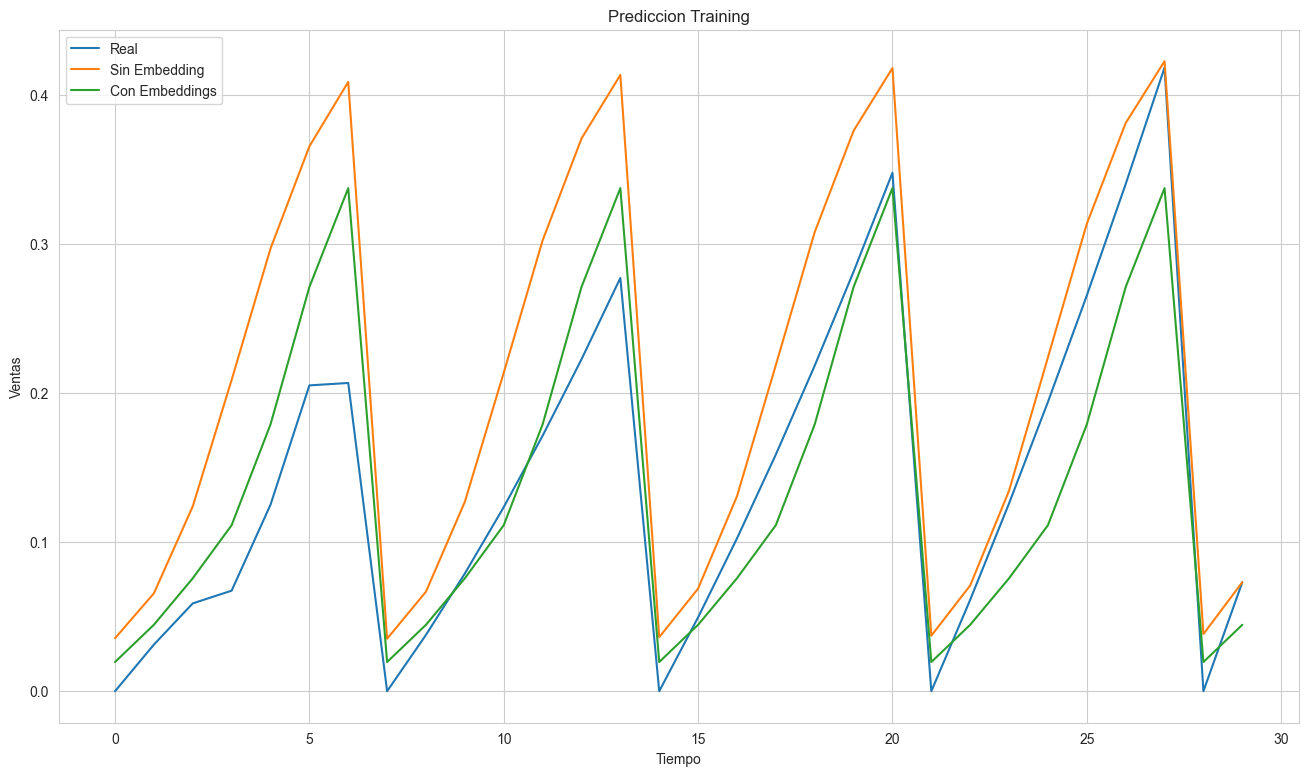

In [18]:
pred0 = model0.predict([training_data])
pred1 = model.predict([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']])

cuantos=30
offset=150
predic_sin=[]
predic_emb=[]
reales=[]
for i in range(0,cuantos):
    predic_sin.append(pred0[i+offset][0])
    predic_emb.append(pred1[i+offset][0])
    reales.append(target_data[i+offset])
    
Nc = range(0, cuantos)

plt.plot(Nc, reales)
plt.plot(Nc, predic_sin)
plt.plot(Nc, predic_emb)

plt.gca().legend(('Real','Sin Embedding','Con Embeddings'))
#plt.legend(loc='upper left')
plt.xlabel('Tiempo')
plt.ylabel('Ventas')
plt.title('Prediccion Training')
plt.show()

Pareciera que la curva de red con Embeddings se aproxima un poco más a la curva real

14/14 [==============================] - 0s 2ms/step


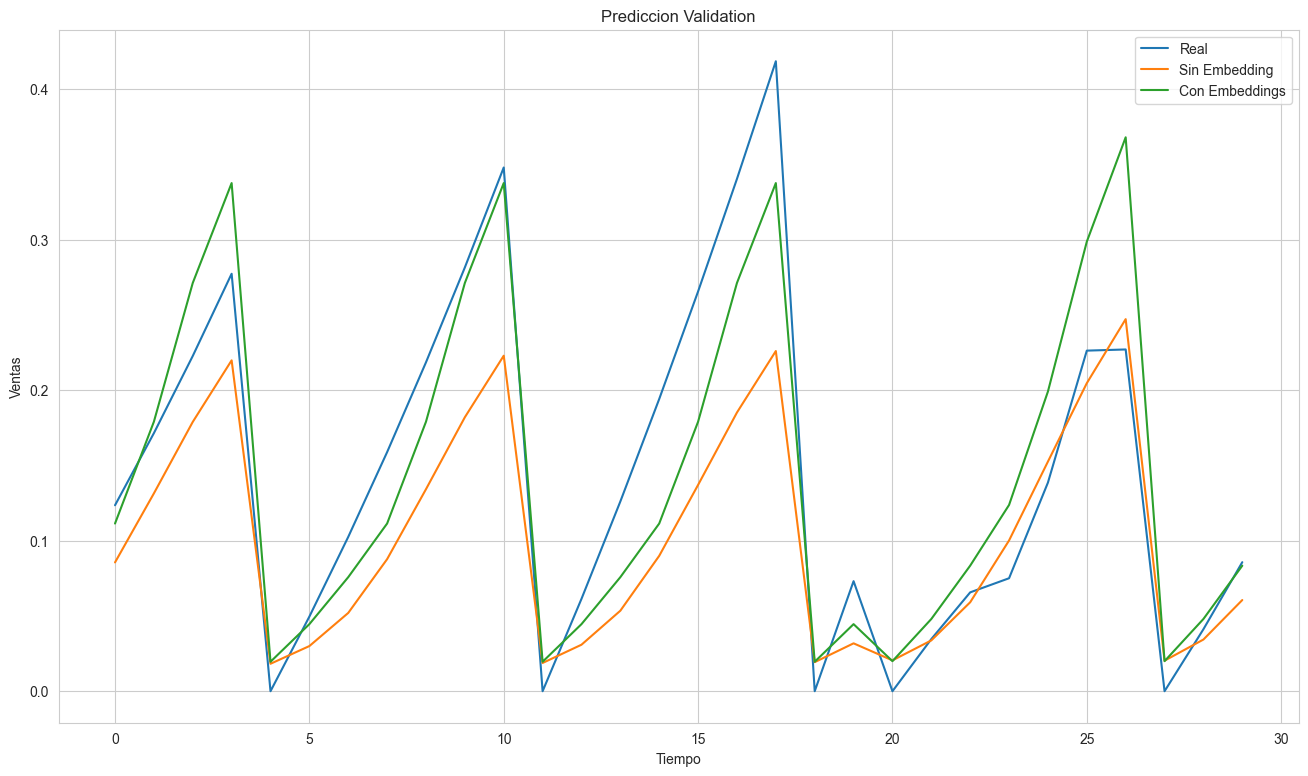

In [19]:
pred0 = model0.predict([valid_data])
pred1 = model.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])

predic_sin=[]
predic_emb=[]
reales=[]
for i in range(0,cuantos):
    predic_sin.append(pred0[i+offset][0])
    predic_emb.append(pred1[i+offset][0])
    reales.append(valid_target[i+1000+offset])
    
Nc = range(0, cuantos)
plt.plot(Nc, reales)
plt.plot(Nc, predic_sin)
plt.plot(Nc, predic_emb)

plt.gca().legend(('Real','Sin Embedding','Con Embeddings'))

plt.xlabel('Tiempo')
plt.ylabel('Ventas')
plt.title('Prediccion Validation')
plt.show()

# 3 - Red Neuronal con más capas Sin Embeddings

In [20]:
model0 = Sequential()
model0.add(Dense(dense_n, input_dim=4, activation=fun_act))
model0.add(Dense(dense_n, activation=fun_act))
model0.add(Dense(1, activation=fun_act))

model0.compile(loss='mean_squared_error', 
              optimizer='adam',
              metrics=['MSE'])

history=model0.fit(training_data, target_data, epochs=EPOCHS)

Epoch 1/50
32/32 [==============================] - 0s 2ms/step - loss: 0.1611 - MSE: 0.1611
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0676 - MSE: 0.0676
Epoch 3/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0428 - MSE: 0.0428
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0376 - MSE: 0.0376
Epoch 5/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0357 - MSE: 0.0357
Epoch 6/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0344 - MSE: 0.0344
Epoch 7/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0333 - MSE: 0.0333
Epoch 8/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0321 - MSE: 0.0321
Epoch 9/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0309 - MSE: 0.0309
Epoch 10/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0297 - MSE: 0.0297
Epoch 11/50
32/32 [==============================] - 0s 2ms/step - l

In [21]:
# evaluamos el modelo
scores = model0.evaluate(training_data, target_data)
print("\n%s: %.4f" % (model0.metrics_names[1], scores[1]))

scores = model0.evaluate(valid_data, valid_target)
print("\n%s: %.4f" % (model0.metrics_names[1], scores[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.0054 - MSE: 0.0054

MSE: 0.0054
14/14 [==============================] - 0s 2ms/step - loss: 0.0120 - MSE: 0.0120

MSE: 0.0120


14/14 [==============================] - 0s 1ms/step
440


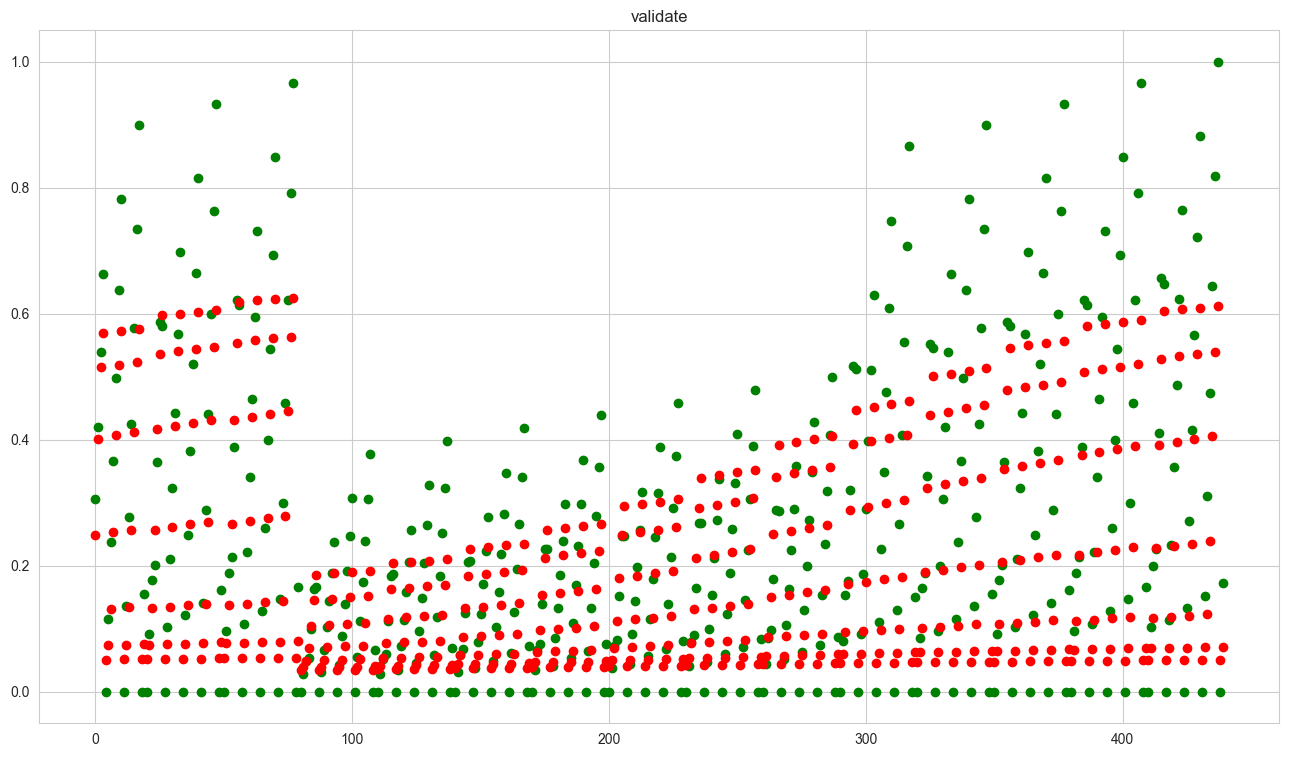

In [22]:
results=model0.predict(valid_data)
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

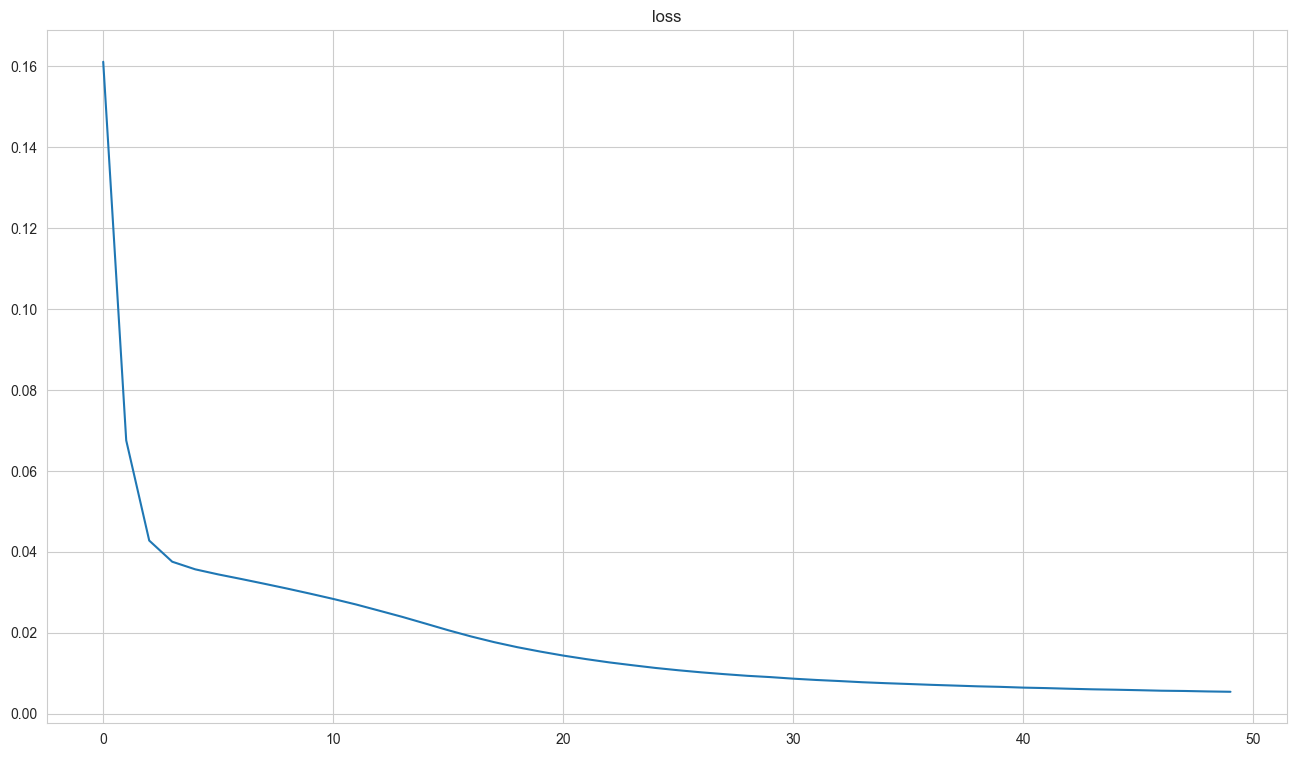

In [23]:
plt.plot(history.history['loss'])
plt.title('loss')
#plt.plot(history.history['mean_squared_error'])
#plt.title('validate loss')
plt.show()

# 4 - Red Neuronal con Embedings y 2 capas

In [24]:
emb_n = 30#tamanio profundidad de embeddings

in_dias = Input(shape=[1], name = 'dias')
emb_dias = Embedding(7, emb_n)(in_dias)
in_meses = Input(shape=[1], name = 'meses')
emb_meses = Embedding(13, emb_n)(in_meses)
in_anios = Input(shape=[1], name = 'anios')
emb_anios = Embedding(6, emb_n)(in_anios)

in_cli = Input(shape=[1], name = 'cli')

fe = concatenate([(emb_dias), (emb_meses),(emb_anios)])

x = Flatten()(fe)
x = Dense(dense_n,activation=fun_act)(x)

x2 = Dense(dense_n,activation=fun_act)(x)

outp = Dense(1,activation=fun_act)(x2)
model = Model(inputs=[in_dias,in_meses,in_anios,in_cli], outputs=outp)

model.compile(loss='mean_squared_error', 
              optimizer='adam',
              metrics=['MSE'])

history=model.fit([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']], target_data, epochs=EPOCHS)

Epoch 1/50
32/32 [==============================] - 1s 2ms/step - loss: 0.1140 - MSE: 0.1140
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0485 - MSE: 0.0485
Epoch 3/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0355 - MSE: 0.0355
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0317 - MSE: 0.0317
Epoch 5/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0274 - MSE: 0.0274
Epoch 6/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0220 - MSE: 0.0220
Epoch 7/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0166 - MSE: 0.0166
Epoch 8/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0128 - MSE: 0.0128
Epoch 9/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0103 - MSE: 0.0103
Epoch 10/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0086 - MSE: 0.0086
Epoch 11/50
32/32 [==============================] - 0s 2ms/step - lo

In [25]:
# evaluamos el modelo
scores = model.evaluate([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']], target_data)
print("\n%s: %.4f" % (model.metrics_names[1], scores[1]))

scores = model.evaluate([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']], valid_target)
print("\n%s: %.4f" % (model.metrics_names[1], scores[1]))

32/32 [==============================] - 0s 1ms/step - loss: 0.0040 - MSE: 0.0040

MSE: 0.0040
14/14 [==============================] - 0s 1ms/step - loss: 0.0055 - MSE: 0.0055

MSE: 0.0055


14/14 [==============================] - 0s 1ms/step
440


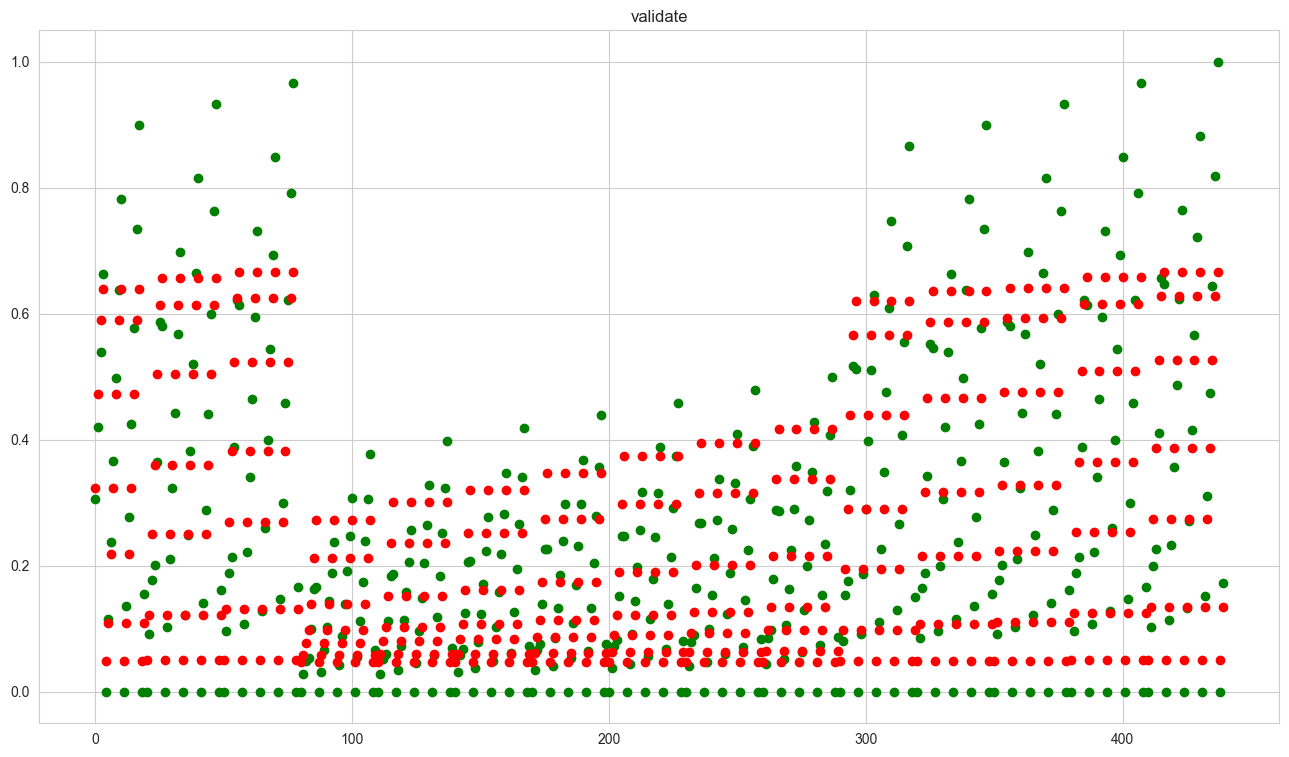

In [26]:
results=model.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

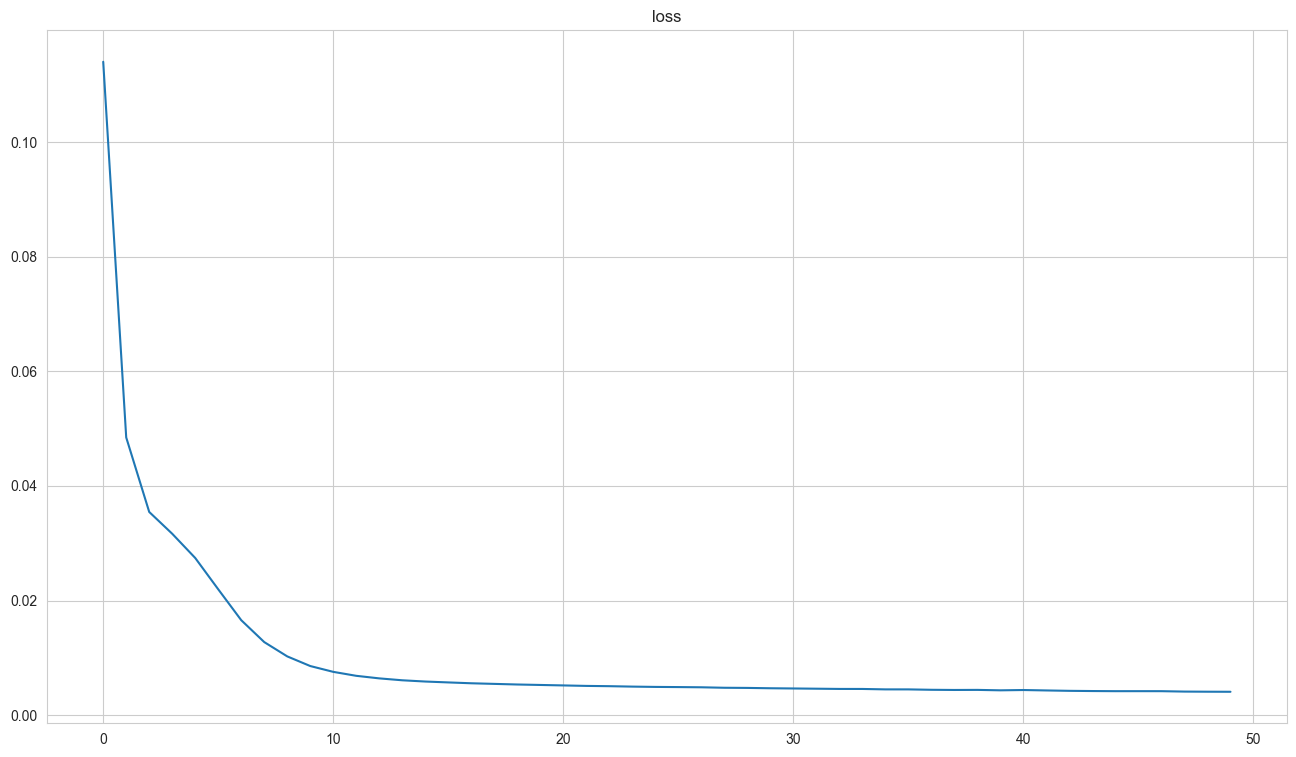

In [27]:
plt.plot(history.history['loss'])
plt.title('loss')
#plt.plot(history.history['mean_squared_error'])
#plt.title('validate loss')
plt.show()

# Comparamos RRNN con 2 capas y RRNN con Embedings 2 capas

14/14 [==============================] - 0s 1ms/step


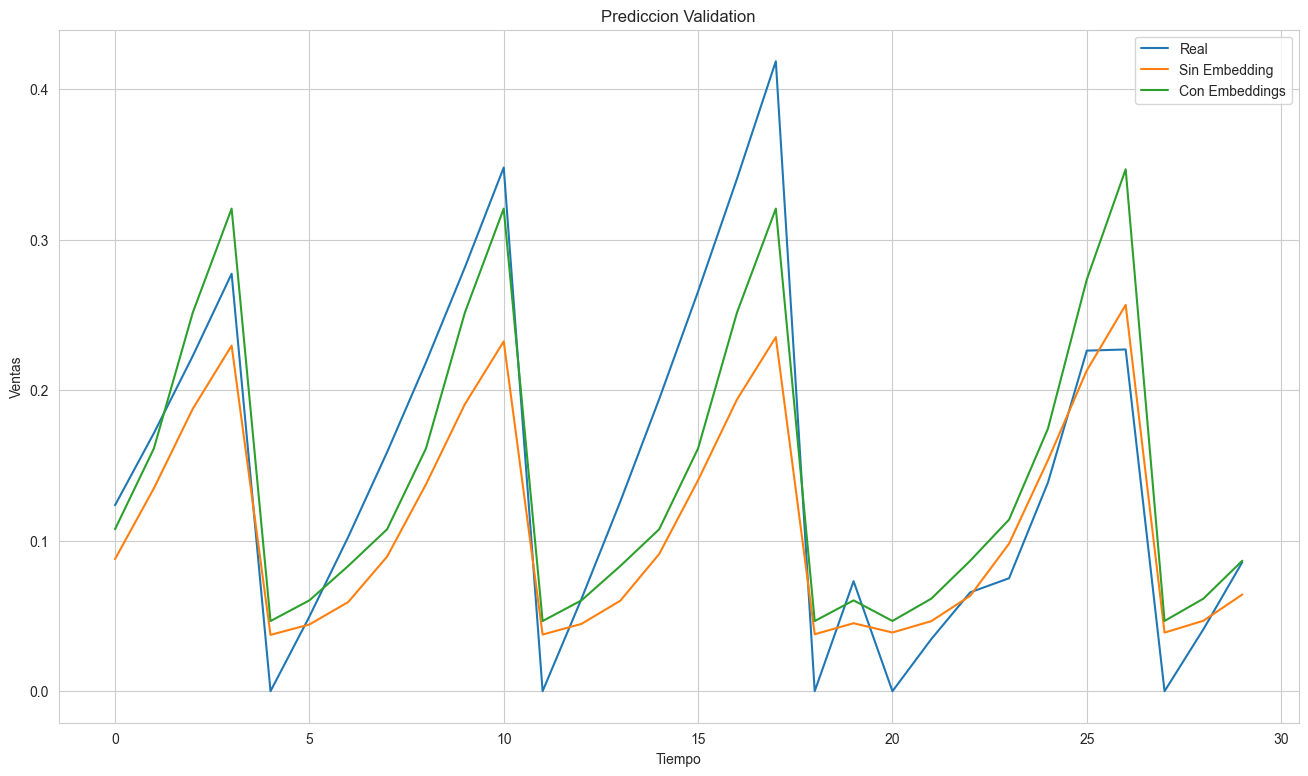

In [28]:
pred0 = model0.predict([valid_data])
pred1 = model.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])

predic_sin=[]
predic_emb=[]
reales=[]
for i in range(0,cuantos):
    predic_sin.append(pred0[i+offset][0])
    predic_emb.append(pred1[i+offset][0])
    reales.append(valid_target[i+1000+offset])
    
Nc = range(0, cuantos)
plt.plot(Nc, reales)
plt.plot(Nc, predic_sin)
plt.plot(Nc, predic_emb)

plt.gca().legend(('Real','Sin Embedding','Con Embeddings'))

plt.xlabel('Tiempo')
plt.ylabel('Ventas')
plt.title('Prediccion Validation')
plt.show()

# 5 - LSTM con Embeddings

In [29]:
emb_n = 30#tamanio profundidad de embeddings

in_dias = Input(shape=[1], name = 'dias')
emb_dias = Embedding(7, emb_n)(in_dias)
in_meses = Input(shape=[1], name = 'meses')
emb_meses = Embedding(13, emb_n)(in_meses)
in_anios = Input(shape=[1], name = 'anios')
emb_anios = Embedding(6, emb_n)(in_anios)

in_cli = Input(shape=[1], name = 'cli')

x = concatenate([(emb_dias), (emb_meses),(emb_anios)])

#x = Flatten()(fe)

x = LSTM(units = 25, return_sequences = True, input_shape = (5, 10))(x)
x = Dropout(0.2)(x)
x = LSTM(units = 25, return_sequences = False, input_shape = (5, 10))(x)
x = Dropout(0.2)(x)

x = Dense(dense_n,activation='relu')(x)
x = Dropout(0.2)(x)

outp = Dense(1,activation='sigmoid')(x)

#outp = Dense(1,activation=fun_act)(x)
model3 = Model(inputs=[in_dias,in_meses,in_anios,in_cli], outputs=outp)

model3.compile(loss='mean_squared_error', 
              optimizer='adam',
              metrics=['MSE'])

model3.summary()

history=model3.fit([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']], target_data, epochs=EPOCHS)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dias (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 meses (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 anios (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 1, 30)        210         ['dias[0][0]']                   
                                                                                            

In [30]:
# evaluamos el modelo
scores = model3.evaluate([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']], target_data)
print("\n%s: %.4f" % (model3.metrics_names[1], scores[1]))

scores = model3.evaluate([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']], valid_target)
print("\n%s: %.4f" % (model3.metrics_names[1], scores[1]))

32/32 [==============================] - 2s 2ms/step - loss: 0.0035 - MSE: 0.0035

MSE: 0.0035
14/14 [==============================] - 0s 2ms/step - loss: 0.0047 - MSE: 0.0047

MSE: 0.0047


14/14 [==============================] - 1s 2ms/step
440


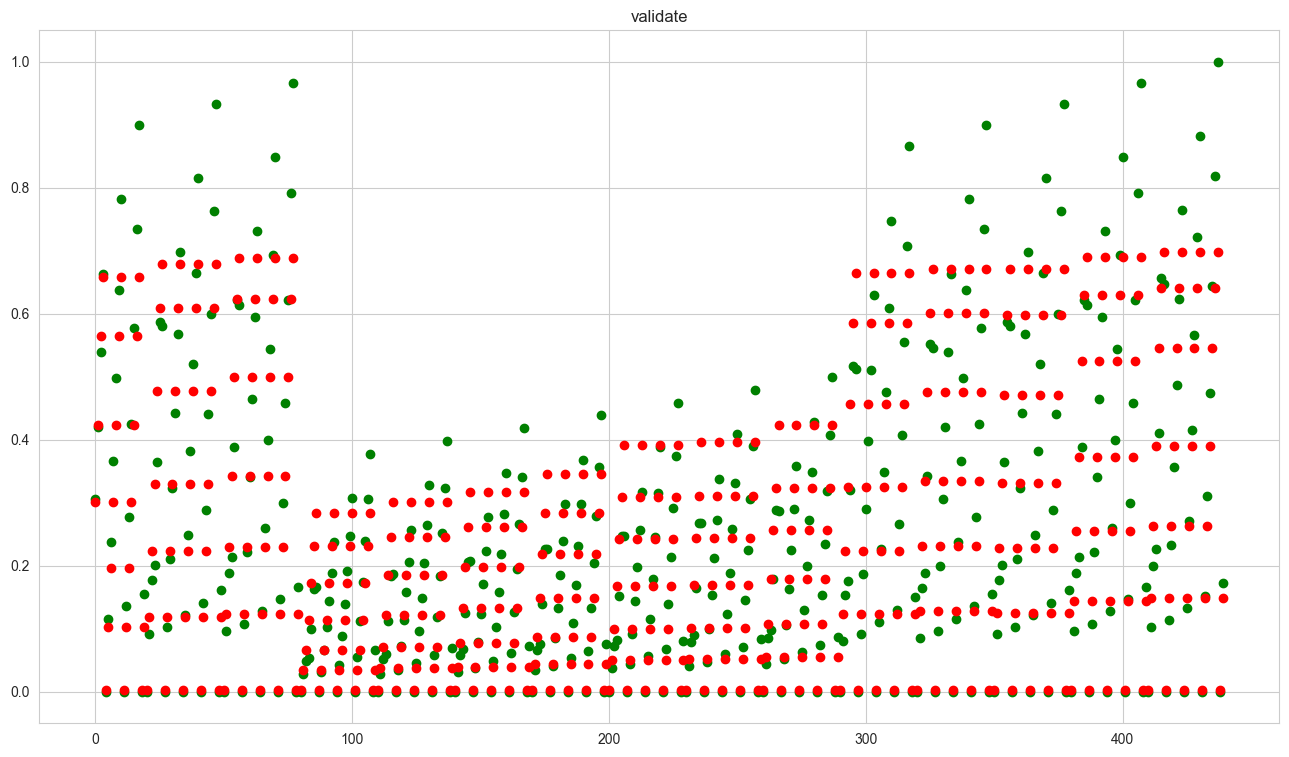

In [31]:
results=model3.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

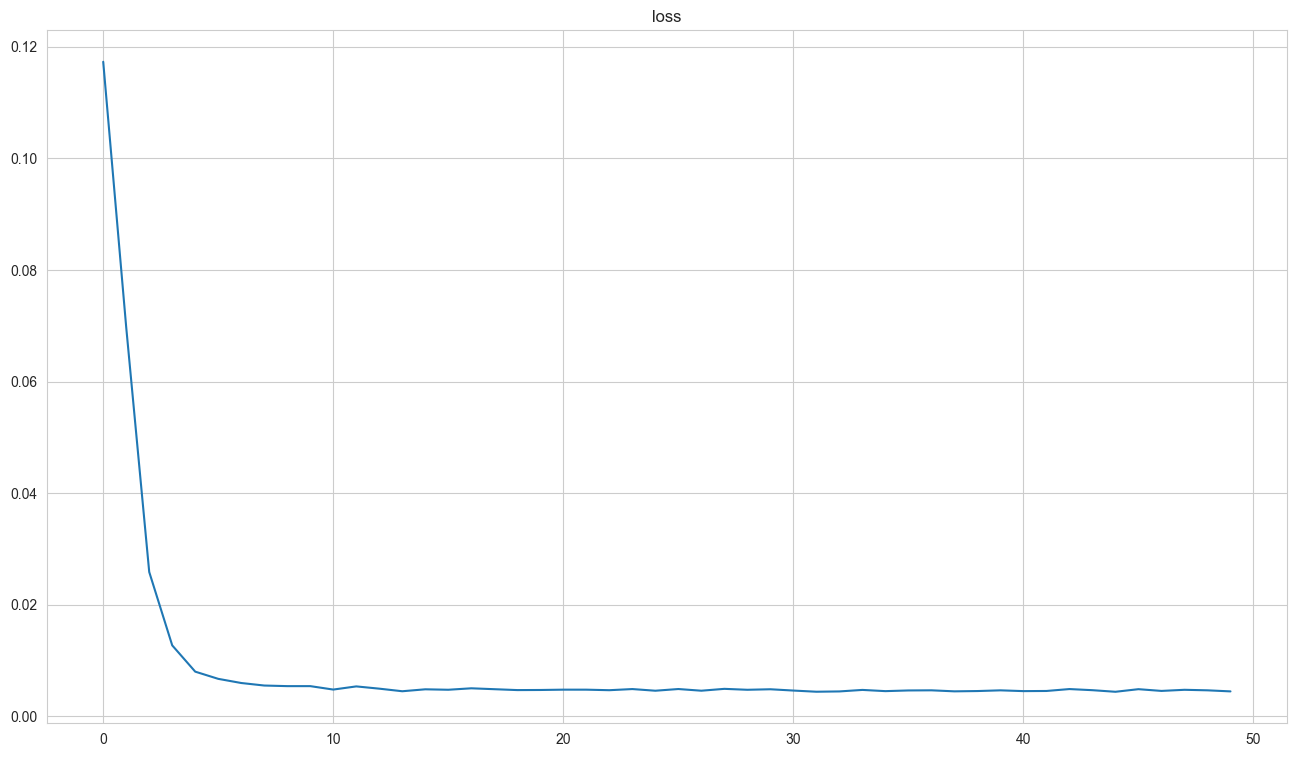

In [32]:
plt.plot(history.history['loss'])
plt.title('loss')
#plt.plot(history.history['mean_squared_error'])
#plt.title('validate loss')
plt.show()

# Comparamos la NN sin EMbedding con la LSTM con Embeddings

14/14 [==============================] - 0s 2ms/step


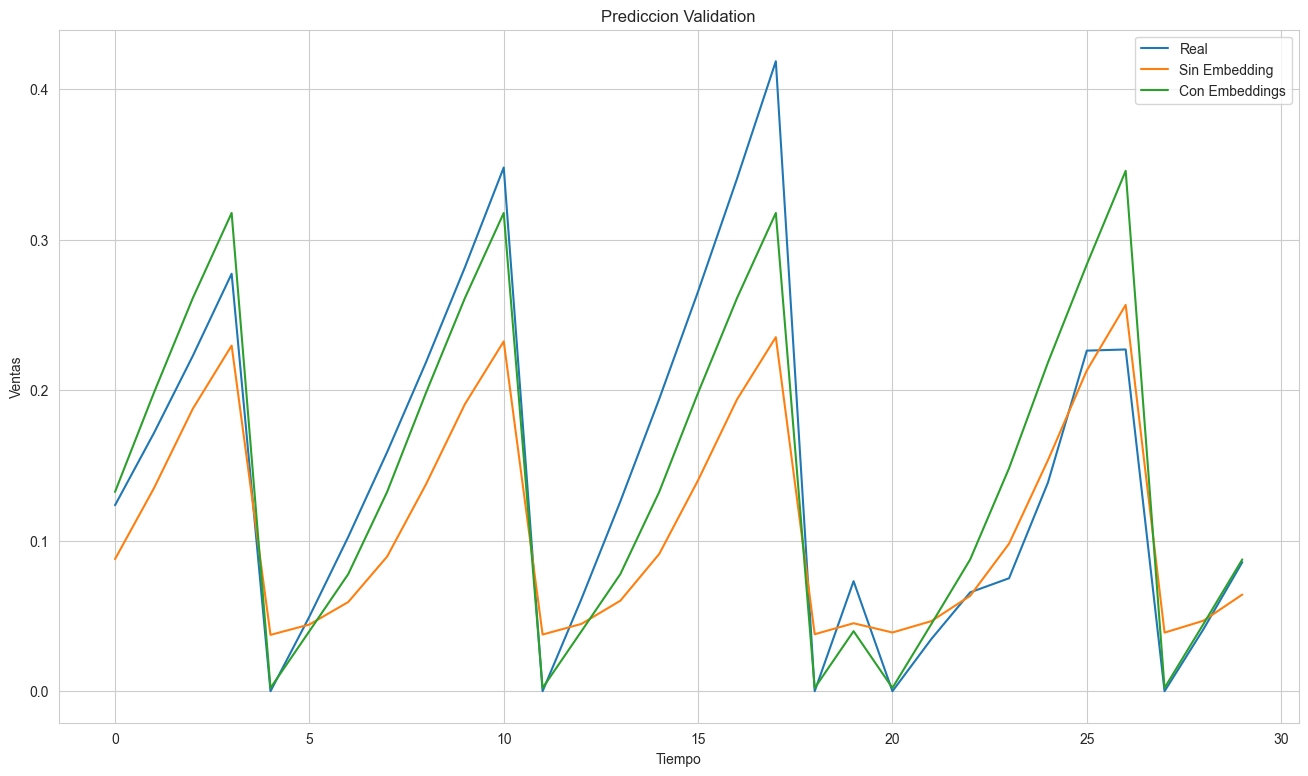

In [33]:
pred0 = model0.predict([valid_data])
pred1 = model3.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])

predic_sin=[]
predic_emb=[]
reales=[]
for i in range(0,cuantos):
    predic_sin.append(pred0[i+offset][0])
    predic_emb.append(pred1[i+offset][0])
    reales.append(valid_target[i+1000+offset])
    
Nc = range(0, cuantos)
plt.plot(Nc, reales)
plt.plot(Nc, predic_sin)
plt.plot(Nc, predic_emb)

plt.gca().legend(('Real','Sin Embedding','Con Embeddings'))

plt.xlabel('Tiempo')
plt.ylabel('Ventas')
plt.title('Prediccion Validation')
plt.show()

# Comparamos la red con Embeddings y la LSTM con Embeddings

14/14 [==============================] - 0s 2ms/step


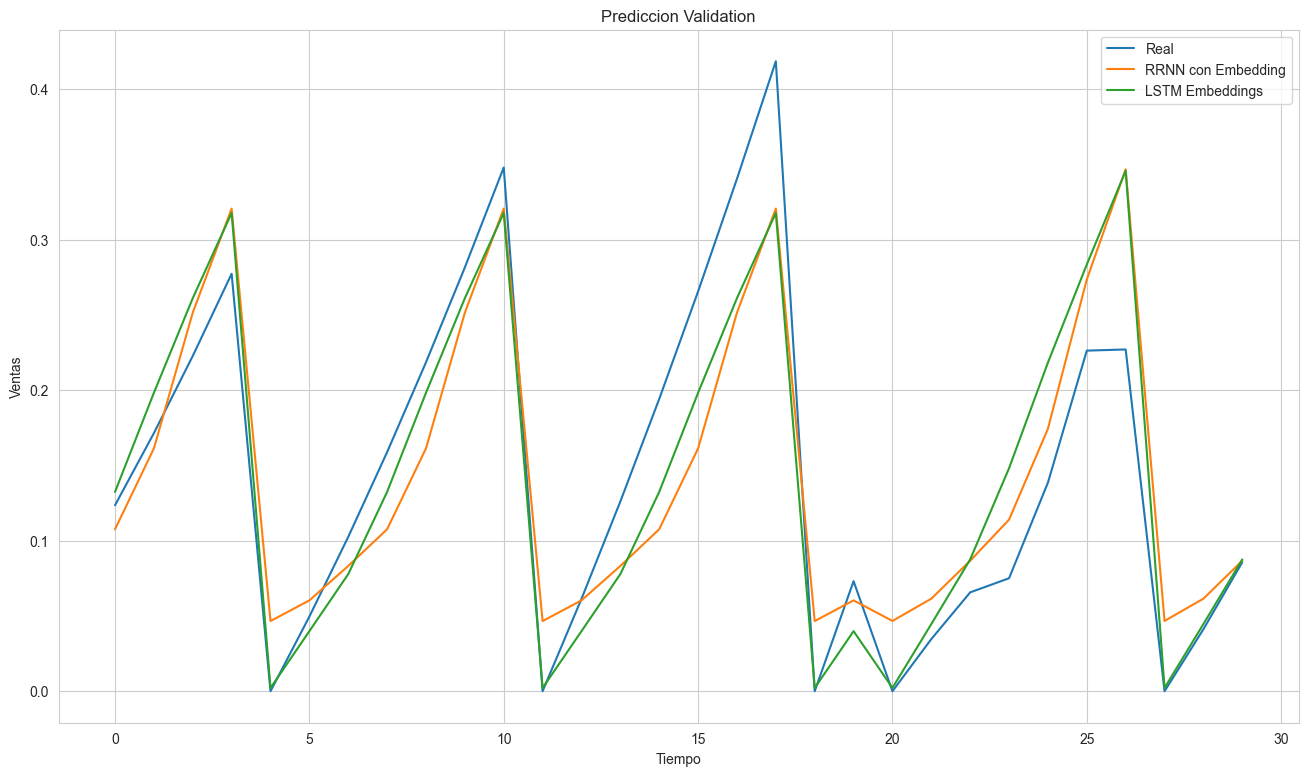

In [34]:
pred0 = model.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])
pred1 = model3.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])

predic_sin=[]
predic_emb=[]
reales=[]
for i in range(0,cuantos):
    predic_sin.append(pred0[i+offset][0])
    predic_emb.append(pred1[i+offset][0])
    reales.append(valid_target[i+1000+offset])
    
Nc = range(0, cuantos)
plt.plot(Nc, reales)
plt.plot(Nc, predic_sin)
plt.plot(Nc, predic_emb)

plt.gca().legend(('Real','RRNN con Embedding','LSTM Embeddings'))

plt.xlabel('Tiempo')
plt.ylabel('Ventas')
plt.title('Prediccion Validation')
plt.show()

Esta última está muy parejo!

# Conclusión

Debo decir que si bien se nota una mejora con el uso de Embeddings, al menos para este ejemplo inventado <br>
no parece haber tanta diferencia con el uso de redes neuronales "normales" (MLP) y valores categóricos.<br>

Creo que sería conveniente Realizar más pruebas en diversos set de datos.

**Copyright**

The notebooks are provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources). Feel free to use the notebooks for your own educational purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).